<a href="https://colab.research.google.com/github/ashlearo/ML/blob/main/%D0%93%D1%80%D1%83%D0%BF%D0%BF%D0%B0_6_%22%D0%93%D1%80%D1%83%D0%BF%D0%BF%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_%D0%9C%D0%9B_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost

In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.impute import SimpleImputer
import catboost as cb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random
import time
import datetime
import shap
shap.initjs()

In [ ]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
data_raw = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
test_raw = pd.read_csv('test.csv')

Посмотрим на данные в основном файле. Тип переменных, количество пропусков, количество уникальных данных.

In [ ]:
item_categories.info()
items.info()
shops.info()
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: 

In [ ]:
data_raw.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
data_raw.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [ ]:
data_raw.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
test_raw.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

Посмотрим на продажи товаров по магазинам. Можно увидеть отдельные выбросы.

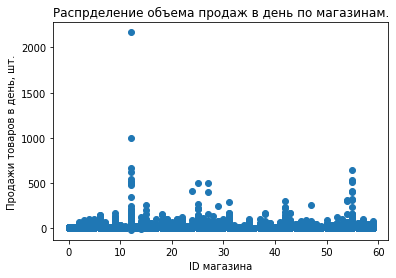

<Figure size 720x432 with 0 Axes>

In [ ]:
plt.scatter(data_raw['shop_id'], data_raw['item_cnt_day'])
plt.title("Распрделение объема продаж в день по магазинам.")
plt.xlabel("ID магазина")
plt.ylabel("Продажи товаров в день, шт.")
plt.figure(figsize=(10,6))
plt.show()

В среднем один магазин продает в день 1 товар.

In [ ]:
df = data_raw.groupby('shop_id')['item_cnt_day'].mean()

In [ ]:
df[1].mean()

1.1114829165199014

Сгруппируем данные по айди магазина и общему количеству единиц проданного товара.

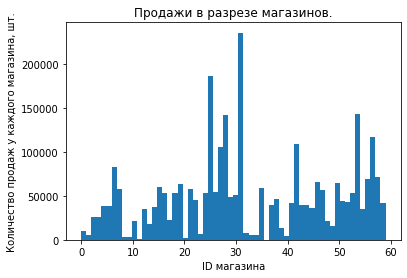

<Figure size 720x432 with 0 Axes>

In [ ]:
plt.hist(data_raw['shop_id'], bins = 60)
plt.title("Продажи в разрезе магазинов.")
plt.xlabel("ID магазина")
plt.ylabel("Количество продаж у каждого магазина, шт.")
plt.figure(figsize=(10,6))
plt.show()

Посмотрим на продажи товаров по месяцам, у нас всего 34 месяца продаж.

---



In [ ]:
sales_by_item_id = data_raw.pivot_table(index=['item_id'],values=['item_cnt_day'],
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

In [ ]:
sales_by_item_id

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,22165,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21803,22166,0,0,0,0,0,0,0,0,0,23,24,32,25,24,21,13,10,15,12,13,13,12,16,11,7,8,12,4,8,10,8,11,5,11
21804,22167,0,0,0,0,0,0,0,0,56,146,96,83,66,57,47,59,41,56,47,47,39,49,49,40,33,46,40,38,31,33,34,29,21,37
21805,22168,2,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


За последние 7 месяцев 12 тыс товаров ни разу не были проданы (из 21 тыс).

In [ ]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


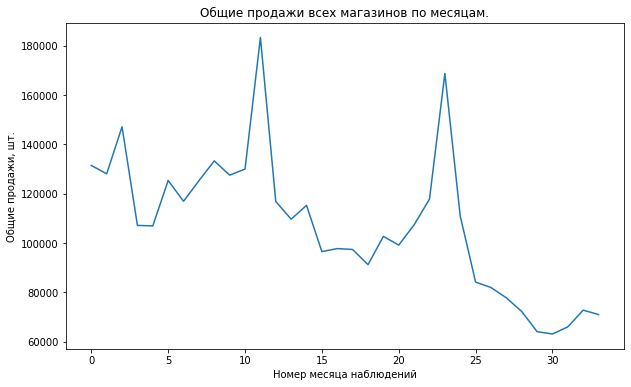

In [ ]:
vis_tem=sales_by_item_id.loc[:, '0':]
months=[int(i) for i in vis_tem.columns]
plt.figure(figsize=(10,6))
plt.plot(months, vis_tem.sum())
plt.title("Общие продажи всех магазинов по месяцам.")
plt.xlabel("Номер месяца наблюдений")
plt.ylabel("Общие продажи, шт.")
plt.show()

Посмотрим на выбросы.

In [ ]:
print('Выбросы по объему продаж:', data_raw['item_cnt_day'][data_raw['item_cnt_day']>500].unique())
print('ВЫбросы по цене товара:', data_raw['item_price'][data_raw['item_price']>50000].unique())

Выбросы по объему продаж: [ 502.  501.  512.  508. 1000.  624.  539.  533.  637.  669.  504. 2169.]
ВЫбросы по цене товара: [ 59200. 307980.  50999.]


Переведем данные в корректный формат.

In [ ]:
data_raw.date=data_raw.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

Попробуем объединить данные, чтобы добавить дополнительные признаки.

In [ ]:
train = data_raw.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

Убираем нулевые значения в колонках "цена", "ID магазина", "ID товара", убираем возвраты.

In [ ]:
train = train[(train.item_price > 0) & (train.shop_id > 0) & (train.item_id > 0) & (train.item_cnt_day > 0)]


Делим датасет на тренинговую и валидационную выборки с помощью рэндом, корректируем тестовую выборку, чтобы входящие в нее параметры совпадали с тестовым файлом из датасета.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(42)
X_train, X_val= train_test_split(train, test_size=0.32, random_state=42, shuffle=True)

X_val = X_val[X_val['shop_id'].isin(test_raw['shop_id'])]
X_val = X_val[X_val['item_id'].isin(test_raw['item_id'])]


Смотрим на размер получившейся валидационной выборки - 20%.

In [ ]:
X_train.dropna(inplace=True)
print('Количество строк в тренинговой выборке:', X_train.shape[0])
print('Количество строк в валидационной выборке:', X_val.shape[0])
print('Количество строк в тренинговой выборке: %s (%.f%% от общего количества)' % (X_train.shape[0], ((X_train.shape[0]/train.shape[0])*100)))
print('Количество строк в валидационной выборке: %s (%.f%% от общего количества)' % (X_val.shape[0], ((X_val.shape[0]/X_train.shape[0])*100)))


Количество строк в тренинговой выборке: 1984671
Количество строк в валидационной выборке: 391140
Количество строк в тренинговой выборке: 1984671 (68% от общего количества)
Количество строк в валидационной выборке: 391140 (20% от общего количества)


Создаем новые столбцы признаков для тестовой выборки и отдельно для валидационной.

In [ ]:
train_monthly_test = X_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly_val = X_val[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

Группируем датасет по месяцам и добавляем средние значения цены и среднее значение продаж по товару. Чтобы использовать эти данные в качестве фичей.

In [ ]:
train_monthly_test = train_monthly_test.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly_test = train_monthly_test.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly_test.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
train_monthly_val = train_monthly_val.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly_val = train_monthly_val.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly_val.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
train_monthly_test

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,1,2,5572,6610.0,1322.0,6.0,1.2,5
1,0,1,2,5573,560.0,560.0,1.0,1.0,1
2,0,1,2,5574,560.0,560.0,1.0,1.0,1
3,0,1,2,5576,6693.0,2231.0,3.0,1.0,3
4,0,1,2,5609,2381.0,2381.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...
1227477,33,59,75,4181,6450.0,1290.0,5.0,1.0,5
1227478,33,59,75,5383,4390.0,4390.0,1.0,1.0,1
1227479,33,59,79,17717,4309.5,861.9,8.0,1.6,5
1227480,33,59,83,22087,238.0,119.0,5.0,2.5,2


Убираем выбросы.

In [ ]:
train_monthly_test = train_monthly_test.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 50000')
train_monthly_val = train_monthly_val.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 50000')

In [ ]:
train_monthly_test

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,1,2,5572,6610.0,1322.0,6.0,1.2,5
1,0,1,2,5573,560.0,560.0,1.0,1.0,1
2,0,1,2,5574,560.0,560.0,1.0,1.0,1
3,0,1,2,5576,6693.0,2231.0,3.0,1.0,3
4,0,1,2,5609,2381.0,2381.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...
1227477,33,59,75,4181,6450.0,1290.0,5.0,1.0,5
1227478,33,59,75,5383,4390.0,4390.0,1.0,1.0,1
1227479,33,59,79,17717,4309.5,861.9,8.0,1.6,5
1227480,33,59,83,22087,238.0,119.0,5.0,2.5,2


Извлекаем из даты месяц и год продажи.

In [ ]:
train_monthly_test['year'] = train_monthly_test['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly_test['month'] = train_monthly_test['date_block_num'].apply(lambda x: (x % 12))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_monthly_val['year'] = train_monthly_val['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly_val['month'] = train_monthly_val['date_block_num'].apply(lambda x: (x % 12))

Преверяем корреляцию получившихся параметров между сосбой. Транзакции коррелируют с количеством продаж, поэтому в дальнейшем их удалим.

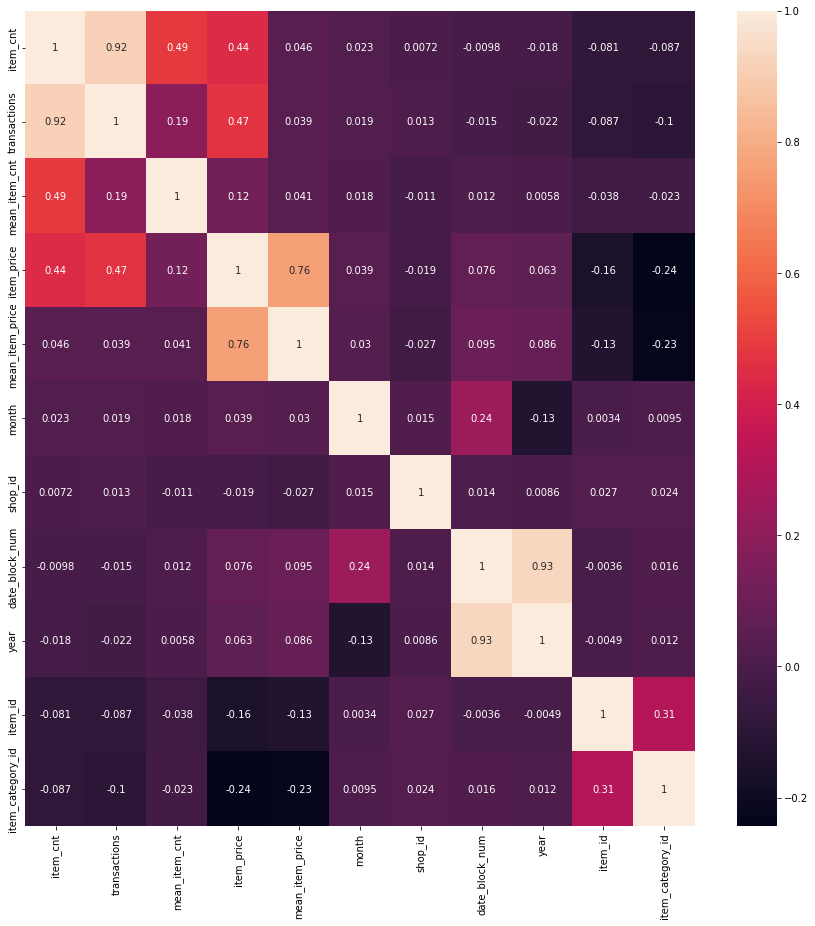

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
highcorr_vars = (train_monthly_test.corr().item_cnt.sort_values(ascending=False)[:20]).index
sns.heatmap(train_monthly_test[highcorr_vars].corr(), annot=True)
plt.show()

Проверяем, что нет нулевых значений.

In [ ]:
train_monthly_test.isnull().mean().sort_values(ascending=False).head(40)

date_block_num      0.0
shop_id             0.0
item_category_id    0.0
item_id             0.0
item_price          0.0
mean_item_price     0.0
item_cnt            0.0
mean_item_cnt       0.0
transactions        0.0
year                0.0
month               0.0
dtype: float64

In [ ]:
train_monthly_val.isnull().mean().sort_values(ascending=False).head(40)

date_block_num      0.0
shop_id             0.0
item_category_id    0.0
item_id             0.0
item_price          0.0
mean_item_price     0.0
item_cnt            0.0
mean_item_cnt       0.0
transactions        0.0
year                0.0
month               0.0
dtype: float64

Вынимаем из тренингового датасета продажи, чтобы в дальнейшем использовать их для проверки модели.

In [ ]:
y_train = train_monthly_test['item_cnt'].values
train_monthly_test.drop(['item_cnt', 'transactions'], axis=1, inplace=True)
X_train = train_monthly_test


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_val = train_monthly_val['item_cnt'].values
train_monthly_val.drop(['item_cnt', 'transactions'], axis=1, inplace=True)
X_val = train_monthly_val

Определяем фичи для передачи в кэтбуст.

In [ ]:
cat_features_mask = (X_train.dtypes == "object").values


In [ ]:
X_train = X_train[X_train.columns[~cat_features_mask]]

Задаем параметры catboost, оптимизированные с помощью gridsearch (код в конце ноутбука, он очень долго выполняется, поэтому вынесен отдельно).

In [ ]:
cb_model = cb.CatBoostRegressor(
    depth = 8,
    l2_leaf_reg = 5,
    learning_rate = 0.1)

In [ ]:
X_train

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,mean_item_cnt,year,month
0,0,1,2,5572,6610.0,1322.0,1.2,2013,0
1,0,1,2,5573,560.0,560.0,1.0,2013,0
2,0,1,2,5574,560.0,560.0,1.0,2013,0
3,0,1,2,5576,6693.0,2231.0,1.0,2013,0
4,0,1,2,5609,2381.0,2381.0,1.0,2013,0
...,...,...,...,...,...,...,...,...,...
1227477,33,59,75,4181,6450.0,1290.0,1.0,2015,9
1227478,33,59,75,5383,4390.0,4390.0,1.0,2015,9
1227479,33,59,79,17717,4309.5,861.9,1.6,2015,9
1227480,33,59,83,22087,238.0,119.0,2.5,2015,9


Обучаем catboost на наших данных.

In [ ]:
cb_model.fit(X_train, y_train, verbose = False)

KeyboardInterrupt: ignored

Считаем эффективность модели. RMSE = 0,1 (среднеквадратичная ошибка) , R2Score = 0.99 (коэф. детерминации, показывает зависимость результата от модели).

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
cb_train_pred = cb_model.predict(X_train)
print(rmse(y_train, cb_train_pred))
print(r2_score(y_train, cb_train_pred))

Предсказание для валидационной выборки и эффективность модели.

In [ ]:
cb_pred = cb_model.predict(X_val)

Считаем эффективность модели на валидационной выборке. RMSE = 0,17 (среднеквадратичная ошибка) , R2Score = 0.99 (коэф. детерминации, показывает зависимость результата от модели).

In [ ]:
print(rmse(y_val, cb_pred))
print(r2_score(y_val, cb_pred))

Гридсерч для подбора оптимальных параметров модели, этот метод перебирает все возможные комбинации заданных параметров и считает rmse для определения наиболее подходящей комбинации, разбивая выборку на несколько непересекающихся частей и на каждой части отдельно смотря качество.

In [ ]:
#from catboost import CatBoostRegressor
#model = CatBoostRegressor()
#grid = {'iterations':[250,500],
#       'learning_rate': [0.05, 0.1],
#       'depth': [6, 8],
#       'l2_leaf_reg': [5, 10]}

#grid_search_result = model.grid_search(grid,
#                                   X=X_train,
#                                   y=y_train,
#                                   plot=True)

In [ ]:
#grid_search_result['params']

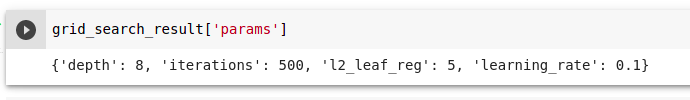

Посмотрим на ключевые признаки изменения количества продаж, исходя из нашей модели. Воспользуемся для этого библиотекой shap. Из графика видно, что наибольшее значение имеет цена товара, средние продажи, и средние продажи за месяц.

In [ ]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_val)

In [ ]:
shap.summary_plot(shap_values, X_val)


Создаем тестовую выборку, добавляем недостающие столбцы.

In [ ]:
test_set_new = test_raw.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [ ]:
test_set_new['year'] = 2015
test_set_new['month'] = 11
test_set_new['date_block_num']=34

Добавляем недостающие столбцы из тестовой выборки, которая не принимала участие в обучении модели.

In [ ]:
temp= X_train.copy()
temp=temp.groupby(['shop_id', 'item_id']).mean().reset_index()
test_set_new = test_set_new.merge(temp[['shop_id', 'item_id', 'item_price', 'mean_item_price', 'mean_item_cnt' ]], how='left', on=['shop_id', 'item_id'])

Удаляем лишние тектовые столбцы (название магазина и т.п.)

In [ ]:
test_set_new = test_set_new.drop(['ID','item_name', 'shop_name', 'item_category_name'], axis=1)

In [ ]:
test_set_new

Мы видим, что в датасете довольно много порпусков в колонках "цена товара", "средняя цена товара", "средние продажи". Для того, чтобы заполнить датасет целиком мы формируем датафрейм с полным набором данных, группируем его по товару и заполняем НАНы средними значениями. Финально, эта стратегия показала худший результат, чем оставление NAN.

In [ ]:
full_data = train_monthly_test.merge(train_monthly_val, how='outer')

In [ ]:
test_set_new.item_price = full_data.groupby('item_id').item_price.transform(lambda x: x.fillna(x.mean()))                 # item_price
test_set_new.mean_item_price = full_data.groupby('item_id').mean_item_price.transform(lambda x: x.fillna(x.mean()))       # mean_item_price
test_set_new.mean_item_cnt = full_data.groupby('item_id').mean_item_cnt.transform(lambda x: x.fillna(x.mean()))           # mean_item_cnt

Посмотрим на количество пропущенных значений - пропусков нет.

In [ ]:
test_set_new.isna().sum()

Предсказываем значение для тестовой выборки.

In [ ]:
cb_test_pred = cb_model.predict(test_set_new)

Создаем итоговый датафрейм с предсказанием продаж на следующий месяц.

In [ ]:
submission = pd.DataFrame({
    "ID": test_raw.index,
    "item_cnt_month": cb_test_pred
})

In [ ]:
submission.set_index('ID')

In [ ]:
submission.to_csv("submission.csv")

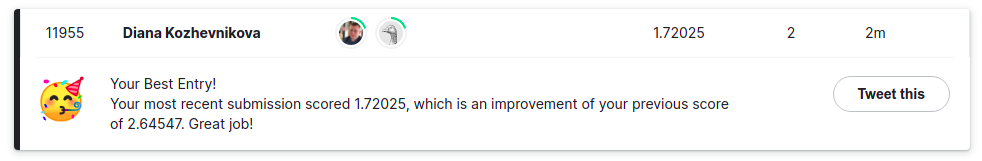